In [3]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 54.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Epoch 1/4
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 241ms/step - accuracy: 0.3981 - loss: 1.8883 - val_accuracy: 0.6939 - val_loss: 0.8581
Epoch 2/4
127/127 ━━━━━━━━━━━━━━━━━━━━ 33s 248ms/step - accuracy: 0.6080 - loss: 1.0740 - val_accuracy: 0.7480 - val_loss: 0.6513
Epoch 3/4
127/127 ━━━━━━━━━━━━━━━━━━━━ 33s 247ms/step - accuracy: 0.6484 - loss: 0.9083 - val_accuracy: 0.7717 - val_loss: 0.5957
Epoch 4/4
127/127 ━━━━━━━━━━━━━━━━━━━━ 33s 246ms/step - accuracy: 0.6793 - loss: 0.7840 - val_accuracy: 0.7835 - val_loss: 0.5651


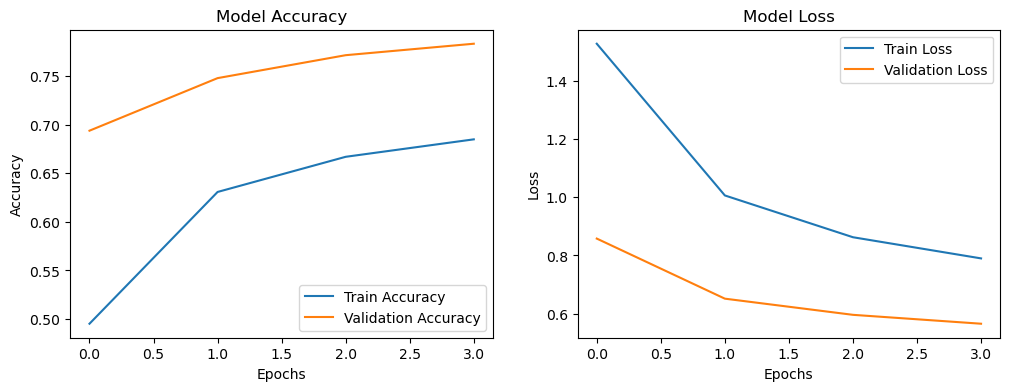

In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Paths
dataset_path = '/Users/anithach/Downloads/COCO Food Items.v1i.tensorflow/train'
annotations_file = '/Users/anithach/Downloads/_annotations.csv'

# Load annotations
df = pd.read_csv(annotations_file)

# Extract image file names and labels
image_paths = [os.path.join(dataset_path, fname) for fname in df['filename']]
labels = df['class'].values  # Assuming 'category' is the column name for labels

# Encode labels to numerical values
unique_labels = list(set(labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
numerical_labels = [label_map[label] for label in labels]

# Convert labels to categorical format (one-hot encoding)
num_classes = len(unique_labels)
categorical_labels = to_categorical(numerical_labels, num_classes=num_classes)

# Split into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, categorical_labels, test_size=0.2, random_state=42)

# Function to load and preprocess images
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)  # Read image file
    image = tf.image.decode_jpeg(image, channels=3)  # Decode image to RGB
    image = tf.image.resize(image, (224, 224))  # Resize to match MobileNet input
    image = image / 255.0  # Normalize image
    return image, label

# TensorFlow Dataset pipeline
def data_generator(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).shuffle(len(image_paths)).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create TensorFlow datasets
train_dataset = data_generator(train_paths, train_labels)
val_dataset = data_generator(val_paths, val_labels)

# Load MobileNetV2 model without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom layers for food classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)  # Dynamic number of categories

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=8)

# Save model
model.save('food_calorie_model.h5')

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [15]:
import urllib.request

# URL for COCO pre-trained weights
weights_url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"
weights_path = "mask_rcnn_coco.h5"

# Download the file
print("Downloading COCO weights...")
urllib.request.urlretrieve(weights_url, weights_path)
print("Download complete! File saved as 'mask_rcnn_coco.h5'")

Download complete! File saved as 'mask_rcnn_coco.h5'


In [17]:
pip install tensorflow numpy scipy matplotlib opencv-python pyyaml pillow

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install git+https://github.com/matterport/Mask_RCNN.git

  Cloning https://github.com/matterport/Mask_RCNN.git to /private/var/folders/w3/8b4lbxtd5bsfgqzq2x6fk9w40000gn/T/pip-req-build-_zictxw6
  Running command git clone --filter=blob:none --quiet https://github.com/matterport/Mask_RCNN.git /private/var/folders/w3/8b4lbxtd5bsfgqzq2x6fk9w40000gn/T/pip-req-build-_zictxw6
  Resolved https://github.com/matterport/Mask_RCNN.git to commit 3deaec5d902d16e1daf56b62d5971d428dc920bc
  Preparing metadata (setup.py) ... done
  Created wheel for mask-rcnn: filename=mask_rcnn-2.1-py3-none-any.whl size=56921 sha256=9d501da18a908a883c64efda247031eaf43c93b89b70670a21210ccf0a3abccb
  Stored in directory: /private/var/folders/w3/8b4lbxtd5bsfgqzq2x6fk9w40000gn/T/pip-ephem-wheel-cache-9eud6em5/wheels/77/0d/08/04ae515636a8be7d9dc31ef20bf231bb3b7c9d0bf2c8d1d239
Successfully built mask-rcnn
Note: you may need to restart the kernel to use updated packages.


In [19]:
import mrcnn
print("Mask R-CNN is installed successfully!")

Mask R-CNN is installed successfully!


In [24]:
from tensorflow.keras import layers as KL
from tensorflow.keras import models as KM
from tensorflow.keras import backend as K

In [27]:
pip install git+https://github.com/akTwelve/Mask_RCNN.git

  Cloning https://github.com/akTwelve/Mask_RCNN.git to /private/var/folders/w3/8b4lbxtd5bsfgqzq2x6fk9w40000gn/T/pip-req-build-8ypohd7h
  Running command git clone --filter=blob:none --quiet https://github.com/akTwelve/Mask_RCNN.git /private/var/folders/w3/8b4lbxtd5bsfgqzq2x6fk9w40000gn/T/pip-req-build-8ypohd7h
  Resolved https://github.com/akTwelve/Mask_RCNN.git to commit d9f01dcd83b1e90e5ea0b4b6d5ba753770e114ac
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
